### 数据探索：怎样从数据中找到用户的 RFM 值

#### 定义问题：RFM（Recency、Frequency、Monetary）
* R 是新进度：代表自用户上次消费以来的天数
* F 是消费频率：代表用户是否频繁使用服务
* M 是消费金额：代表用户在一段时间内消费的总金额

#### 数据预处理

In [21]:
import pandas as pd  # 导入 Pandas


df_sales = pd.read_csv('易速鲜花订单记录.csv')  # 载入数据
df_sales.head()  # 显示头几行数据

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


##### 数据可视化

In [22]:
import matplotlib.pyplot as plt  # 导入 Matplotlib.pylot 模块


# 构建月度的订单数的 DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])  # 转化日期格式
 # 每个月的订单数量
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()

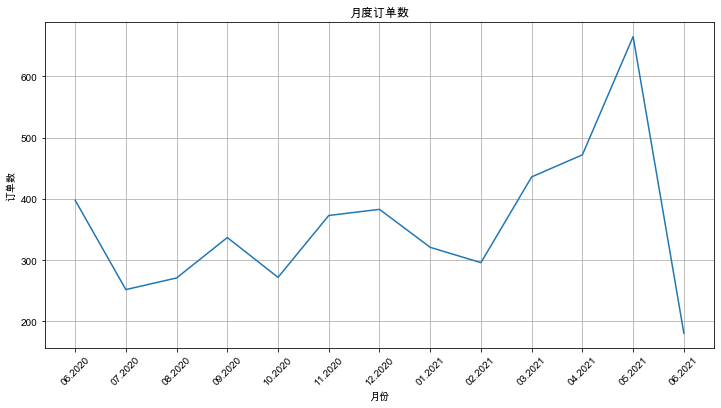

In [23]:
# 设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True, figsize=(12, 6), legend=False)
ax.set_xlabel('月份')  # X 轴 Label
ax.set_ylabel('订单数')  # Y 轴 Label
ax.set_title('月度订单数')  # 图标题
# 设定 X 轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)),
    [x.strftime('%m.%Y') for x in df_orders_monthly.index],
    rotation=45
)
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.show()  # 绘图

##### 数据清洗

In [24]:
df_sales = df_sales.drop_duplicates()  # 删除重复的数据行
df_sales.describe()  # df_sales 的统计信息

,数量,单价,用户码
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


In [25]:
# 清洗掉数量小于等于 0 的数据
df_sales = df_sales.loc[df_sales['数量'] > 0]
df_sales.describe() 

,数量,单价,用户码
count,84112.000000,84112.000000,84112.000000
mean,10.760236,3.005032,15337.732963
std,34.018906,15.365085,392.074855
min,1.000000,0.000000,14681.000000
25%,2.000000,1.250000,15021.000000
50%,5.000000,1.950000,15333.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,3155.950000,16019.000000


#### 求 RFM 值

In [26]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价']  # 计算每单的总价
df_sales.head()  # 显示头几行数据

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


##### 构建用户层级表

In [27]:
# 生成以用户码为主键的结构 df_user
df_user = pd.DataFrame(df_sales['用户码'].unique())
df_user.columns = ['用户码']  # 设定字段名
# 按用户码排序
df_user = df_user.sort_values(by='用户码', ascending=True).reset_index(drop=True)
df_user  # 显示 df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


##### 求出 R 值

In [28]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])  # 转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index()  # 构建消费日期信息
df_recent_buy.columns = ['用户码', '最近日期']  # 设定字段值
# 计算最新日期与上次消费日期的天数
df_recent_buy['R 值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days 
# 把上次消费距最近日期的天数（R 值）合并至 df_user 结构
df_user = pd.merge(df_user, df_recent_buy[['用户码', 'R 值']], on='用户码')
df_user.head()  # 显示 df_user 头几行数据

,用户码,R 值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


##### 求出 F 值

In [29]:
# 计算每个用户消费次数、构建 df_frequency 对象
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index()
df_frequency.columns = ['用户码', 'F 值']  # 设定字段名称
# 把消费频率整合至 df_user 结构
df_user = pd.merge(df_user, df_frequency, on='用户码')
df_user.head()

,用户码,R 值,F 值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


##### 求出 M 值

In [30]:
# 根据消费总额、构建 df_revenue 对象
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index()
df_revenue.columns = ['用户码', 'M 值']  # 设定指定名称
# 把消费金额整合至 df_user 结构
df_user = pd.merge(df_user, df_revenue, on='用户码')
df_user.head()

,用户码,R 值,F 值,M 值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10
